I start by reading the necessary files in order to obtain the data, for the preprocessing steps I do the following: normalise the features extracted from the data and use a random forest classifier to obtain the most important features. Afterwards I use GridSearchCV to experiment with several models and also to optimise their hyperparameters. Given the best model in terms of the f1 score, I then provide 4 more models: a voting classifier that uses the other models used in GridSeacrhCV and then a simple neural network using keras, the novel XGBoost which is ideal for tabular data and the most recent TabNet, also focused for tabular data.

For the product I thought of building an model that is used to either accept or reject a given password. This password is comprised of 3 single digit numbers. In order for the password to be accepted both the numbers and their respective intonations must be correct.

Note: The data used is not yet publicly available.

# 1. Preprocessing and model testing:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


#from IPython.display import Audio
import IPython.display as ipd
from IPython.display import clear_output
from tqdm import tqdm
import librosa
import pyloudnorm as pyln

The first thing to do is to read the files and the labels dataframe:

In [2]:
files = glob.glob('/Training/*.wav')
len(files)

20000

In [3]:
labels = pd.read_csv('trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


Given that our labels are strings we need to encode them since machine learning models can't interpret strings/text like we would like:

In [4]:
labelencoder = LabelEncoder()

labels['Intonation Encoded'] = labelencoder.fit_transform(labels['intonation'])
labels

,File ID,digit_label,participant,intonation,Intonation Encoded
0,0000000.wav,4,S73,question,3
1,0000001.wav,2,S88,excited,1
2,0000002.wav,70,S5,neutral,2
3,0000003.wav,2,S85,bored,0
4,0000004.wav,4,S30,excited,1
...,...,...,...,...,...
19995,0019995.wav,90,S163,excited,1
19996,0019996.wav,10,S99,question,3
19997,0019997.wav,90,S46,question,3
19998,0019998.wav,19,S13,neutral,2


### Feature Extraction:

The following <code>get_feat()</code> function extracts the following features from the audio files: Mel Frequency Cepstral, a.k.a, mfcc (set of features that describe the overall shape of a spectral envelope), spectral rolloff (is the frequency below which a specified percentage of the total spectral energy lies), spectral centroid (calculated as the weighted mean of the frequencies it represents where the so call center of mass of the sound is located), spectral contrast (the level difference between the peaks and valleys of a given spectrum) and finally the spectral bandwith (the difference between the upper and lower frequencies in the continuous band of frequencies). 

Every single one of the mentioned features provides several arrays of features (in simple terms each feature is a list of lists). This makes for an unnecessary amount of features. To work around this I decided to only use as features statistical measures of these features such as the mean, median, standard deviation, the maximum and minimum values.

In [5]:
def get_feat(x, fs):

    ft1 = librosa.feature.mfcc(x, sr=fs) ## calculate the mfcc
    ft2 = librosa.feature.spectral_rolloff(x)[0] ## calculate the spectral rolloff
    ft3 = librosa.feature.spectral_centroid(x)[0] ## calculate the spectral centroid
    ft4 = librosa.feature.spectral_contrast(x)[0] ## calculate the spectral contrast
    ft5 = librosa.feature.spectral_bandwidth(x)[0] ## calculate the spectral bandwith
    ## Now we get the statistical results for these features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1),
                           np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1))) ## calculate the statistical features for each row and then stack the arrays in a sequence(horizontally)
    ft2_trunc = np.array([np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)])
    ft3_trunc = np.array([np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)])
    ft4_trunc = np.array([np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)])
    ft5_trunc = np.array([np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)])

    return ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc

<code>getPitch()</code> function allows us to extract features such as the power, the pitch mean, the pitch standard deviation and the fraction of voiced region.

In [6]:
def getPitch(x,fs,winLen=0.02):
    #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

<code>getXy()</code> extracts the feature vector from the audio files and their corresponding labels.

In [7]:
def getXy(files, labels_file, label_name, scale_audio=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        yi = list(labels_file[labels_file['File ID']==fileID][label_name])[0] ## label_name is a new parameter added. This parameters value is a string and will represent the column of the labels

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)

        meter = pyln.Meter(fs, block_size = 0.2) ## as an extra feature I also extracted the perceived loundness of the audio file
        loudness = meter.integrated_loudness(x)
        
        mfcc, spectral_rolloff_features, spectral_centroid_features, spectral_contrast_features, spectral_bandwith_features = get_feat(x, fs)

        pitch_feat = np.array([power, pitch_mean, pitch_std, voiced_fr, loudness])
        xi = np.concatenate((pitch_feat, mfcc, spectral_rolloff_features, spectral_centroid_features, spectral_contrast_features, spectral_bandwith_features)) ## concatenate all features
        X.append(xi)
        y.append(yi)
    return np.array(X),np.array(y)

In [8]:
X,y = getXy(files, labels_file=labels, label_name = 'Intonation Encoded', scale_audio=True)

100%|██████████| 20000/20000 [1:47:34<00:00,  3.10it/s]  


In [9]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y[:10])

The shape of X is (20000, 149)
The shape of y is (20000,)
The labels vector is [3 0 2 3 2 3 0 0 2 0]


In [10]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


## Feature Normalization

Here I normalize the features obtained in the previous cells. This normalization allows the features to have similar weights between each other. Without this normalization we would have features that correspond to different measures and would therefore have very different values. For instance we could have features like 0.01, 5.45 and then features with higher orders of magnitude like 1000 or 500. This would make larger features carry more weight. With normalization we avoid this problem.

In [11]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

## Feature and Model selection:

In order to get the best models possible we must select features. Even though normalized features carry similar weights their importance is a very different story. In the following cells we use a random forest classifier to determine the most important features. Why a random forest classifier? Well because nothing is better than having a machine learning algorithm tell us what features it found the most important.

In [12]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100), max_features = 50)
sel.fit(X_norm, y)

SelectFromModel(estimator=RandomForestClassifier(), max_features=50)

In [13]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False,  True,  True,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Now we filter our feature vector to include only the important features.

In [14]:
X_important = X_norm[:,sel.get_support()]

In [15]:
X_important.shape

(20000, 26)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_important,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14000, 26), (6000, 26), (14000,), (6000,))

## **Models**:

In order to not only experiment with several machine learning models, but also optimise them I use GridSeacrhCV.
For this study I chose the following classifiers: SVC, MLP, K nearest neighbours, the decision tree classifier and the sgd classifier.

In [17]:
## Let's take advantage of this library and select a few models
classifiers = []

svc = svm.SVC()
classifiers.append(svc)

mlp = MLPClassifier()
classifiers.append(mlp)

knn = KNeighborsClassifier()
classifiers.append(knn)

dt = DecisionTreeClassifier()
classifiers.append(dt)

sgd = SGDClassifier()
classifiers.append(sgd)

Now I define, for every classifier chosen, a set of features to experiment with. The point is to optimise the models chosen by tuning their hyperparameters using GridSeacrhCV.

In [18]:
parameters = []

parameters_svc = {'C': np.logspace(-3, 2, 6),  
              'gamma': np.logspace(-3, 2, 6), 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf']}  
parameters.append(parameters_svc)

parameters_mlp = {'max_iter': [30,50,75,100,120,200],
                  'hidden_layer_sizes':[(100,2), (80,2), (60,2), (40,2)],
                  'learning_rate': ['constant', 'adaptive'],
                  'learning_rate_init': [0.001,0.003,0.005,0.0009],
                 'activation': ['relu', 'tanh', 'logistic']}

parameters.append(parameters_mlp)

parameters_knn = {'n_neighbors': [2, 4, 5, 8,10], "weights": ['uniform','distance'] }
parameters.append(parameters_knn)

parameters_dt = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'],
                'max_depth': np.arange(3, 10)}
parameters.append(parameters_dt)

parameters_sgd = {'max_iter': [100,200,500,1000], 'loss':['hinge', 'log', 'perceptron'],
                  'penalty': ['l1', 'l2']}
parameters.append(parameters_sgd)

Using GridsearchCV and the for loop we iterate through all the classifers and obtain the best one between all of the parameters.

In [19]:
best_models = []
for i in tqdm(range(len(classifiers))):
    
    model_grid = GridSearchCV(classifiers[i], parameters[i], refit=True, n_jobs = -1, verbose=1)
    model_grid.fit(X_train, y_train)
    print('Clssifier:', str(classifiers[i]))
    print(classification_report(y_val, model_grid.predict(X_val)))
    best_models.append(model_grid.best_estimator_)

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 39.5min finished


Clssifier: SVC()


 20%|██        | 1/5 [39:44<2:38:56, 2384.11s/it]

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1507
           1       0.72      0.70      0.71      1533
           2       0.61      0.58      0.60      1447
           3       0.74      0.73      0.74      1513

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 83.5min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 95.6min finished
/home/diogo_mota/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 40%|████      | 2/5 [2:15:32<2:49:40, 3393.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Clssifier: MLPClassifier()
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      1507
           1       0.66      0.58      0.62      1533
           2       0.45      0.50      0.47      1447
           3       0.66      0.68      0.67      1513

    accuracy                           0.60      6000
   macro avg       0.61      0.60      0.60      6000
weighted avg       0.61      0.60      0.60      6000

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.3s finished


Clssifier: KNeighborsClassifier()


 60%|██████    | 3/5 [2:16:19<1:19:38, 2389.45s/it]

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1507
           1       0.71      0.68      0.69      1533
           2       0.56      0.57      0.57      1447
           3       0.75      0.68      0.72      1513

    accuracy                           0.66      6000
   macro avg       0.67      0.66      0.66      6000
weighted avg       0.67      0.66      0.67      6000

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    7.1s finished
 80%|████████  | 4/5 [2:16:26<27:54, 1674.84s/it]  

Clssifier: DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.61      0.55      0.58      1507
           1       0.57      0.56      0.57      1533
           2       0.44      0.53      0.48      1447
           3       0.62      0.59      0.60      1513

    accuracy                           0.56      6000
   macro avg       0.56      0.56      0.56      6000
weighted avg       0.56      0.56      0.56      6000

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   21.0s finished
100%|██████████| 5/5 [2:16:48<00:00, 1641.68s/it]

Clssifier: SGDClassifier()
              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1507
           1       0.58      0.56      0.57      1533
           2       0.44      0.49      0.46      1447
           3       0.65      0.59      0.62      1513

    accuracy                           0.55      6000
   macro avg       0.56      0.55      0.56      6000
weighted avg       0.56      0.55      0.56      6000



In [20]:
best_models

[SVC(C=10.0),
 MLPClassifier(hidden_layer_sizes=(100, 2)),
 KNeighborsClassifier(n_neighbors=8, weights='distance'),
 DecisionTreeClassifier(max_depth=8),
 SGDClassifier(loss='log', max_iter=200, penalty='l1')]

### The overall best model (looking only into the f1 score):

In order to compare the models previously optimised we will be lookin at their f1 score. As we can see from the classification reports, the best model is the svc model with an f1 score of 0.69 on the validation data. (note that I did not take into account other aspects for instance overfitting when chosing the best model. One way I could have done this was using GridSearchCV's <code>.best_estimator_</code>)

In [21]:
overall_best = best_models[0]

In [22]:
yt_p = overall_best.predict(X_train)
yv_p = overall_best.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.8687142857142857
Validation  Accuracy 0.6888333333333333


Knowing that accuracies don't always mean that the model chosen is the best, let's take a look at another quality measure.

#### Confusion Matrices:

Let's take a look at the confusion matrices of our SVC model for the training and validation data.

Text(0.5, 1.01, 'Training Confusion Matrix')

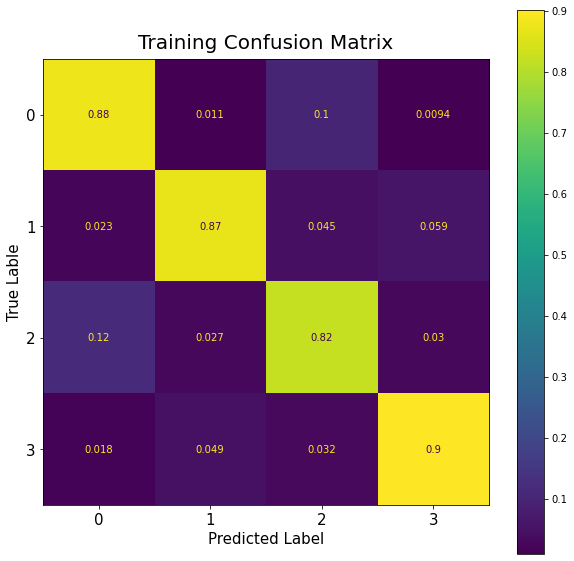

In [23]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
plot_confusion_matrix(overall_best, X_train, y_train, normalize='true', ax=axs)
axs.tick_params(labelsize=15)
axs.set_xlabel('Predicted Label', fontsize=15)
axs.set_ylabel('True Lable',fontsize=15)
axs.set_title('Training Confusion Matrix', fontsize=20, y=1.01)

The confusion matrix allows us to check, just as the name suggest, what classes were confused with others. As we can see by the training confusion matrix the class that our model struggled the most with was the neutral intonation, having confused it the most with the bored intonation.

Text(0.5, 1.01, 'Training Confusion Matrix')

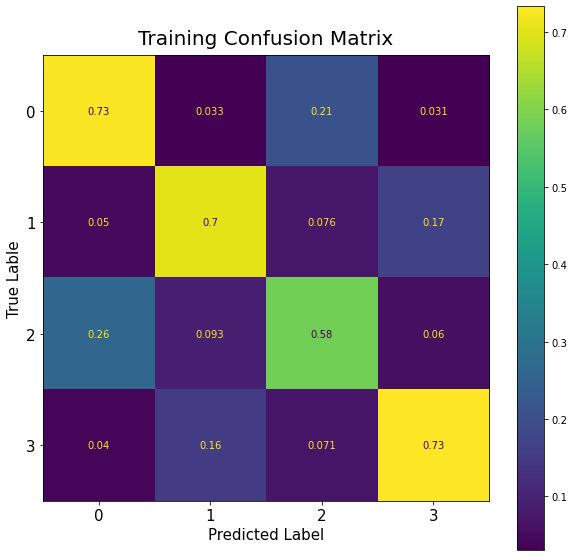

In [24]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
plot_confusion_matrix(overall_best, X_val, y_val, normalize='true', ax=axs)
axs.tick_params(labelsize=15)
axs.set_xlabel('Predicted Label', fontsize=15)
axs.set_ylabel('True Lable',fontsize=15)
axs.set_title('Training Confusion Matrix', fontsize=20, y=1.01)

The validation confusion matrix provides very similar information as the training confusion matrix. Once again the hardest intonation to classify was the neutral intonation. This could mean that the participants neutral and bored intonations are very similar. Perhaps if we listened to the audios ourselves we would struggle to classify them.

### The voting Classifier:

Let's try something different. Let's see if by "combining" all, but the best classifier we can build a model that matches or even surpasses the SVC model.

What do I mean by combining these classifiers? Well we are going to take into account all of their classification decisions and only then classify the sample. In other words we are building a voting classifier!.

In [25]:
estimators = [('mlp', best_models[1]), 
              ('knn', best_models[2]), ('dt', best_models[3]), ('sgd', best_models[4])]

voting_clf = VotingClassifier(estimators = estimators, voting = 'soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('mlp',
                              MLPClassifier(hidden_layer_sizes=(100, 2))),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=8,
                                                   weights='distance')),
                             ('dt', DecisionTreeClassifier(max_depth=8)),
                             ('sgd',
                              SGDClassifier(loss='log', max_iter=200,
                                            penalty='l1'))],
                 n_jobs=-1, voting='soft')

In [ ]:
print(classification_report(y_val, voting_clf.predict(X_val)))

#### Confusion Matrices:

Text(0.5, 1.01, 'Training Confusion Matrix')

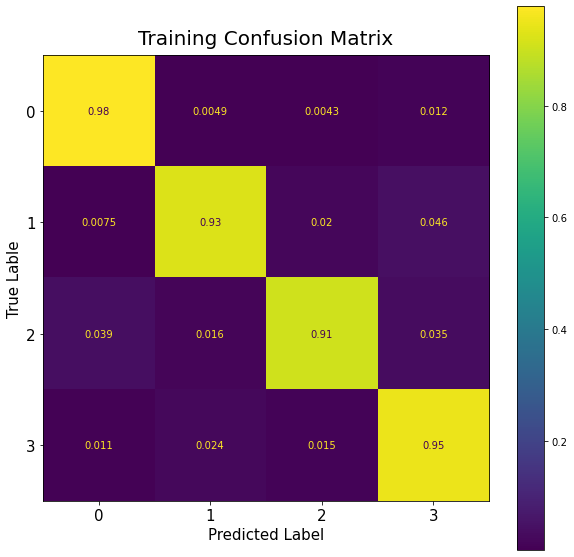

In [26]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
plot_confusion_matrix(voting_clf, X_train, y_train, normalize='true', ax=axs)
axs.tick_params(labelsize=15)
axs.set_xlabel('Predicted Label', fontsize=15)
axs.set_ylabel('True Lable',fontsize=15)
axs.set_title('Training Confusion Matrix', fontsize=20, y=1.01)

Comparing this training confusion matrix with the SVC's we can clearly see who  classified the classes better. However this is only training, meaning that the model could have overfitted. (Spoiler alert: it did)

Text(0.5, 1.01, 'Validation Confusion Matrix')

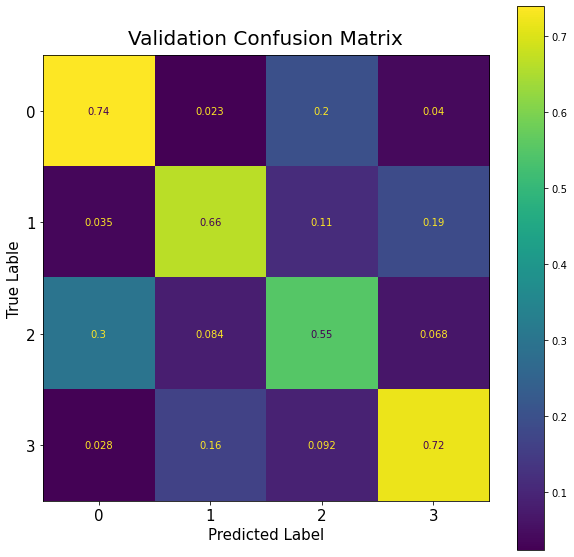

In [27]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
plot_confusion_matrix(voting_clf, X_val, y_val, normalize='true', ax=axs)
axs.tick_params(labelsize=15)
axs.set_xlabel('Predicted Label', fontsize=15)
axs.set_ylabel('True Lable',fontsize=15)
axs.set_title('Validation Confusion Matrix', fontsize=20, y=1.01)

By comparing the validation confusion matrices we conclude that the SVC performed better overall having confused less intonations. However we can see that the voting classifier performed better with the bored intonation having classified correctly 74% of the samples (bored intonation samples) in contrats to the 73% of the SVC model.

### Neural Network model:

Let's take things to a higher level and develope a fully customisable neural network using keras.

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, LSTM

In [29]:
dataframe = pd.DataFrame(y, columns = ['Intonation encoded'])

#### One hot encoding the labels:

Since we are using keras we will be encoding our intonation labels using one hot vectors instead of the previously used method.

In [30]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
one_hot_y = enc.fit_transform(dataframe[['Intonation encoded']]).toarray()

In [31]:
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(X_important,one_hot_y,test_size=0.3)

In [32]:
len(nn_X_train), len(nn_y_train)

(14000, 14000)

In [33]:
## 80% training, 20% validation
train_size = int(0.80*len(nn_X_train))
val_size = len(nn_X_train)-train_size

nn_X_val = np.array(nn_X_train[:val_size])
partial_X_train = np.array(nn_X_train[train_size:])

nn_y_val = np.array(nn_y_train[:val_size])
partial_y_train = np.array(nn_y_train[train_size:])

In [34]:
partial_X_train.shape, partial_y_train.shape

((2800, 25), (2800, 4))

#### Network Structure:

Here I build a simple neural network using only fully connected layers (Dense layers) and adding some Dropout layers. The concept of dropout comes from the idea of randomly dropping units during the training process of a NN. The main advantage of this concept is the reduction of overfitting in the NN. In other words dropout is a regularization technique that prevents co-adaptation on training data, therefore reducing overfitting.

In [35]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=350,
                    batch_size=100,
                    validation_data=(nn_X_val, nn_y_val),
                    verbose=1)

Epoch 1/350
28/28 [==============================] - 1s 13ms/step - loss: 1.3438 - accuracy: 0.2774 - val_loss: 1.2135 - val_accuracy: 0.4461
Epoch 2/350
28/28 [==============================] - 0s 3ms/step - loss: 1.2145 - accuracy: 0.4313 - val_loss: 1.1002 - val_accuracy: 0.5146
Epoch 3/350
28/28 [==============================] - 0s 3ms/step - loss: 1.1166 - accuracy: 0.4960 - val_loss: 1.0405 - val_accuracy: 0.5357
Epoch 4/350
28/28 [==============================] - 0s 3ms/step - loss: 1.0901 - accuracy: 0.5008 - val_loss: 1.0152 - val_accuracy: 0.5311
Epoch 5/350
28/28 [==============================] - 0s 3ms/step - loss: 1.0249 - accuracy: 0.5261 - val_loss: 0.9959 - val_accuracy: 0.5496
Epoch 6/350
28/28 [==============================] - 0s 3ms/step - loss: 0.9913 - accuracy: 0.5611 - val_loss: 0.9852 - val_accuracy: 0.5525
Epoch 7/350
28/28 [==============================] - 0s 3ms/step - loss: 0.9651 - accuracy: 0.5756 - val_loss: 0.9816 - val_accuracy: 0.5596
Epoch 8/350


Epoch 59/350
28/28 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.7516 - val_loss: 1.0387 - val_accuracy: 0.5861
Epoch 60/350
28/28 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.7409 - val_loss: 1.0534 - val_accuracy: 0.5768
Epoch 61/350
28/28 [==============================] - 0s 3ms/step - loss: 0.5935 - accuracy: 0.7557 - val_loss: 1.0607 - val_accuracy: 0.5739
Epoch 62/350
28/28 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.7440 - val_loss: 1.0307 - val_accuracy: 0.6064
Epoch 63/350
28/28 [==============================] - 0s 3ms/step - loss: 0.5722 - accuracy: 0.7628 - val_loss: 1.0360 - val_accuracy: 0.5889
Epoch 64/350
28/28 [==============================] - 0s 3ms/step - loss: 0.5901 - accuracy: 0.7405 - val_loss: 1.0474 - val_accuracy: 0.5871
Epoch 65/350
28/28 [==============================] - 0s 3ms/step - loss: 0.5698 - accuracy: 0.7647 - val_loss: 1.0584 - val_accuracy: 0.5896
Epoch 

28/28 [==============================] - 0s 3ms/step - loss: 0.2888 - accuracy: 0.8915 - val_loss: 1.5218 - val_accuracy: 0.5789
Epoch 174/350
28/28 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 0.8786 - val_loss: 1.4989 - val_accuracy: 0.5979
Epoch 175/350
28/28 [==============================] - 0s 3ms/step - loss: 0.3182 - accuracy: 0.8775 - val_loss: 1.4865 - val_accuracy: 0.5818
Epoch 176/350
28/28 [==============================] - 0s 3ms/step - loss: 0.3055 - accuracy: 0.8819 - val_loss: 1.4975 - val_accuracy: 0.5821
Epoch 177/350
28/28 [==============================] - 0s 3ms/step - loss: 0.3113 - accuracy: 0.8945 - val_loss: 1.4896 - val_accuracy: 0.5854
Epoch 178/350
28/28 [==============================] - 0s 3ms/step - loss: 0.2634 - accuracy: 0.9017 - val_loss: 1.4956 - val_accuracy: 0.5864
Epoch 179/350
28/28 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.8905 - val_loss: 1.5096 - val_accuracy: 0.5707
Epoch 180/350

28/28 [==============================] - 0s 3ms/step - loss: 0.2150 - accuracy: 0.9182 - val_loss: 1.7637 - val_accuracy: 0.5811
Epoch 288/350
28/28 [==============================] - 0s 3ms/step - loss: 0.2103 - accuracy: 0.9242 - val_loss: 1.7786 - val_accuracy: 0.5814
Epoch 289/350
28/28 [==============================] - 0s 3ms/step - loss: 0.2084 - accuracy: 0.9296 - val_loss: 1.7884 - val_accuracy: 0.5764
Epoch 290/350
28/28 [==============================] - 0s 3ms/step - loss: 0.2081 - accuracy: 0.9260 - val_loss: 1.7742 - val_accuracy: 0.5868
Epoch 291/350
28/28 [==============================] - 0s 3ms/step - loss: 0.2417 - accuracy: 0.9065 - val_loss: 1.8110 - val_accuracy: 0.5718
Epoch 292/350
28/28 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.9266 - val_loss: 1.8331 - val_accuracy: 0.5811
Epoch 293/350
28/28 [==============================] - 0s 3ms/step - loss: 0.2243 - accuracy: 0.9240 - val_loss: 1.8326 - val_accuracy: 0.5857
Epoch 294/350

In [37]:
results = model.evaluate(nn_X_test, nn_y_test)

188/188 [==============================] - 0s 941us/step - loss: 1.9478 - accuracy: 0.5823


As we can see from the testing stage, this simple neural network did not perform as well as the SVC. With more time I would have experimented adding LSTM and CNN layers which could greatly boost the models performance.

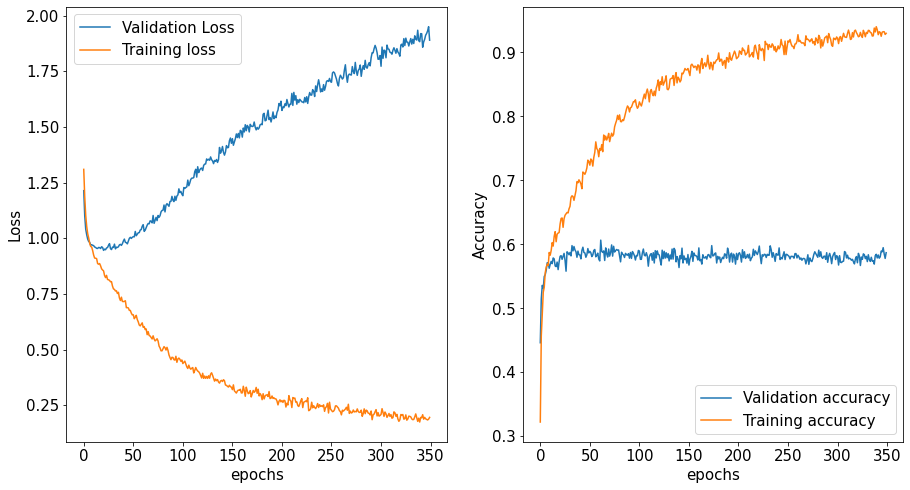

In [38]:
fig, axs = plt.subplots(1,2, figsize=(15,8))
axs[0].plot(history.history['val_loss'], label = 'Validation Loss')
axs[0].plot(history.history['loss'], label = 'Training loss')

axs[0].set_xlabel('epochs', fontsize=15)
axs[0].set_ylabel('Loss', fontsize=15)
axs[0].tick_params(labelsize=15)
axs[0].legend(fontsize=15)

axs[1].plot(history.history['val_accuracy'], label = 'Validation accuracy')
axs[1].plot(history.history['accuracy'], label = 'Training accuracy')

axs[1].set_xlabel('epochs', fontsize=15)
axs[1].set_ylabel('Accuracy', fontsize=15)
axs[1].tick_params(labelsize=15)
axs[1].legend(fontsize=15) 

By looking at the graph on the left we can clearly see that even though we added dropout layers our model overfitted quite a lot which is clearly noticeable when we look at the accuracy graph on the right.

### XGBoost model:

Here we use an extreme gradient boosting model which focuses on computational speed and model performance. This model is ideal for tabular data.

In [17]:
from xgboost import XGBClassifier

In [18]:
xgb_model = XGBClassifier()

In [21]:
xgb_model.fit(X_train, y_train)

[23:05:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
print(classification_report(y_val, xgb_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1516
           1       0.67      0.69      0.68      1434
           2       0.59      0.55      0.57      1559
           3       0.68      0.72      0.70      1491

    accuracy                           0.66      6000
   macro avg       0.66      0.66      0.66      6000
weighted avg       0.66      0.66      0.66      6000



### TabNet model:

The TabNet is a deep tabular data learning architecture. Using sequential attention, it is able to choose which features to use at each decision step, allowing interpretability and more efficient learning.

In [28]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

In [25]:
clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


/home/diogo_mota/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [26]:
clf1_nopreproc.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 1.27001 | train_accuracy: 0.49243 | valid_accuracy: 0.498   |  0:00:03s
epoch 1  | loss: 1.06053 | train_accuracy: 0.54129 | valid_accuracy: 0.54217 |  0:00:06s
epoch 2  | loss: 1.00745 | train_accuracy: 0.5525  | valid_accuracy: 0.54183 |  0:00:09s
epoch 3  | loss: 0.99055 | train_accuracy: 0.57036 | valid_accuracy: 0.55417 |  0:00:12s
epoch 4  | loss: 0.97282 | train_accuracy: 0.57036 | valid_accuracy: 0.56083 |  0:00:15s
epoch 5  | loss: 0.96608 | train_accuracy: 0.58236 | valid_accuracy: 0.56617 |  0:00:18s
epoch 6  | loss: 0.95762 | train_accuracy: 0.5785  | valid_accuracy: 0.564   |  0:00:21s
epoch 7  | loss: 0.95693 | train_accuracy: 0.57857 | valid_accuracy: 0.57217 |  0:00:24s
epoch 8  | loss: 0.96309 | train_accuracy: 0.5835  | valid_accuracy: 0.5665  |  0:00:28s
epoch 9  | loss: 0.94234 | train_accuracy: 0.58421 | valid_accuracy: 0.57283 |  0:00:31s
epoch 10 | loss: 0.93954 | train_accuracy: 0.5945  | valid_accuracy: 0.56433 |  0:00:35s
epoch 11 | loss: 0.92

epoch 93 | loss: 0.73666 | train_accuracy: 0.69    | valid_accuracy: 0.6045  |  0:04:44s
epoch 94 | loss: 0.72202 | train_accuracy: 0.71329 | valid_accuracy: 0.6145  |  0:04:47s
epoch 95 | loss: 0.72157 | train_accuracy: 0.711   | valid_accuracy: 0.61267 |  0:04:50s
epoch 96 | loss: 0.72088 | train_accuracy: 0.70814 | valid_accuracy: 0.60467 |  0:04:54s
epoch 97 | loss: 0.72639 | train_accuracy: 0.71214 | valid_accuracy: 0.60033 |  0:04:57s
epoch 98 | loss: 0.72448 | train_accuracy: 0.70307 | valid_accuracy: 0.608   |  0:05:00s
epoch 99 | loss: 0.70964 | train_accuracy: 0.7     | valid_accuracy: 0.58133 |  0:05:03s
epoch 100| loss: 0.70868 | train_accuracy: 0.72121 | valid_accuracy: 0.60417 |  0:05:06s
epoch 101| loss: 0.70955 | train_accuracy: 0.70657 | valid_accuracy: 0.5965  |  0:05:09s
epoch 102| loss: 0.71752 | train_accuracy: 0.71364 | valid_accuracy: 0.60767 |  0:05:12s
epoch 103| loss: 0.71969 | train_accuracy: 0.71671 | valid_accuracy: 0.60367 |  0:05:14s
epoch 104| loss: 0.70

# 2. Product Idea:

I thought of a product that uses two machine learning algorithms (one to predict a single digit number and another to predict the intonation that these numbers were spoken in). These two models will be used to assess whether or not a spoken sequence of 3 numbers is not only correct but also spoken with the right intonation.

I could have built a model that predicts only the 3 digits of the password/sequence, however I was curious to see how hard it was to implement such an advanced security system that uses voice intonation as part of the password.

As stated above this sequence will be comprised of only single digit numbers. Therefore the first thing to do is to create a dataset of single digit numbers only. 

In [8]:
labels_digit_product = labels[labels['digit_label']<10] ## dataframe with single digit numbers only

In [9]:
labels_digit_product

,File ID,digit_label,participant,intonation,Intonation Encoded
0,0000000.wav,4,S73,question,3
1,0000001.wav,2,S88,excited,1
3,0000003.wav,2,S85,bored,0
4,0000004.wav,4,S30,excited,1
6,0000006.wav,2,S136,neutral,2
...,...,...,...,...,...
19979,0019979.wav,8,S95,question,3
19984,0019984.wav,5,S42,excited,1
19986,0019986.wav,1,S139,excited,1
19989,0019989.wav,9,S105,excited,1


Now I get all the audio files that are in this new dataset. 

In [10]:
test_product_files = ['/home/diogo_mota/Dropbox/QMUL/Semester_B/Machine Learning/Mini_project/TrainingMLEnd/Training/'+val for val in labels_digit_product['File ID']]

Get the feature vector and the labels that are going to be used for the single digit model:

In [11]:
def getXy_product(files, labels_file, scale_audio=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        yi = (list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0],
             list(labels_file[labels_file['File ID']==fileID]['Intonation Encoded'])[0]) ## this time I extract both the intonation and digit labels straight away and split them later

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)

        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)

        meter = pyln.Meter(fs, block_size = 0.2)
        loudness = meter.integrated_loudness(x)
        
        mfcc, spectral_rolloff_features, spectral_centroid_features, spectral_contrast_features, spectral_bandwith_features = get_feat(x, fs)

        pitch_feat = np.array([power, pitch_mean, pitch_std, voiced_fr, loudness])
        xi = np.concatenate((pitch_feat, mfcc, spectral_rolloff_features, spectral_centroid_features, spectral_contrast_features, spectral_bandwith_features))
        X.append(xi)
        y.append(yi)
    return np.array(X),np.array(y)

In [12]:
X_product, y_product = getXy_product(test_product_files,labels_file=labels_digit_product,scale_audio=True)

100%|██████████| 6533/6533 [32:31<00:00,  3.35it/s] 


In [13]:
print('The shape of X is', X_product.shape) 
print('The shape of y is', y_product.shape)
print('The labels vector is', y_product[:10])

The shape of X is (6533, 149)
The shape of y is (6533, 2)
The labels vector is [[4 3]
 [2 1]
 [2 0]
 [4 1]
 [2 2]
 [1 1]
 [3 1]
 [6 3]
 [9 0]
 [9 0]]


In [14]:
# If nan sample, remove them
if np.sum(np.isnan(X_product)):
    idx = np.isnan(X_product).sum(1)>0
    X_product = X_product[~idx]
    y_product = y_product[~idx]
print(np.sum(np.isnan(X_product)))

0


Here we simply normalize the features in order for the features to carry similar weights:

In [15]:
scaler = StandardScaler()
X_product_norm = scaler.fit_transform(X_product)

Here we select the most important features to be used to train our 2 models:

In [16]:
sel2 = SelectFromModel(RandomForestClassifier(n_estimators = 100), max_features = 50)
sel2.fit(X_product_norm, y_product)

SelectFromModel(estimator=RandomForestClassifier(), max_features=50)

Now we filter our feature vector to invlude only the important features:

In [17]:
X_product_important = X_product_norm[:,sel2.get_support()]

In [18]:
X_product_important.shape

(6533, 44)

Now we split our data into training and test data:

In [19]:
X_train_product, X_test_product, y_train_product, y_test_product = train_test_split(X_product_important,y_product,test_size=0.2)
X_train_product.shape, X_test_product.shape, y_train_product.shape, y_test_product.shape

((5226, 44), (1307, 44), (5226, 2), (1307, 2))

## Single Digit Model:

Choose the best model out of the selected using GridSearchCV (just like in the basic solution):

In [45]:
## Here we split the data between training data and validation data
train_size = int(0.80*len(X_train_product))
val_size = len(X_train_product)-train_size

X_val_product = np.array(X_train_product[:val_size])
partial_X_train_product = np.array(X_train_product[train_size:])

y_val_product = np.array(y_train_product[:val_size])
partial_y_train_product = np.array(y_train_product[train_size:])

Get the labels that will be used for the single digit model: 

In [21]:
y_digit_train = [val[0] for val in partial_y_train_product]
y_digit_val = [val[0] for val in y_val_product]

In [22]:
## Let's take advantage of this library and select a few models
classifiers = []

svc_clf = svm.SVC()
classifiers.append(svc_clf)

mlp = MLPClassifier()
classifiers.append(mlp)

knn = KNeighborsClassifier()
classifiers.append(knn)

dt = DecisionTreeClassifier()
classifiers.append(dt)

sgd = SGDClassifier()
classifiers.append(sgd)

In [23]:
parameters = []

parameters_svc = {'C': np.logspace(-3, 2, 6),  
              'gamma': np.logspace(-3, 2, 6), 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf']}  
parameters.append(parameters_svc)

parameters_mlp = {'max_iter': [50, 100, 150],
                  'hidden_layer_sizes':[(100,2), (80,2), (60,2), (40,2)],
                  'learning_rate': ['constant', 'adaptive'],
                  'learning_rate_init': [0.001,0.003,0.005,0.0009],
                 'activation': ['relu', 'tanh', 'logistic']}

parameters.append(parameters_mlp)

parameters_knn = {'n_neighbors': [2, 4, 5, 8,10], "weights": ['uniform','distance'] }
parameters.append(parameters_knn)

parameters_dt = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'],
                'max_depth': np.arange(3, 10)}
parameters.append(parameters_dt)

parameters_sgd = {'max_iter': [100,200,500,1000], 'loss':['hinge', 'log', 'perceptron'],
                  'penalty': ['l1', 'l2']}
parameters.append(parameters_sgd)

In [24]:
for i in tqdm(range(len(classifiers))):
    
    model_grid_digit = GridSearchCV(classifiers[i], parameters[i], refit=True, n_jobs = -1, verbose=1)
    model_grid_digit.fit(partial_X_train_product, y_digit_train)
    print('Clssifier:', str(classifiers[i]))
    print(classification_report(y_digit_val, model_grid_digit.predict(X_val_product)))

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   14.8s finished
 20%|██        | 1/5 [00:15<01:00, 15.11s/it]

Clssifier: SVC()
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       104
           1       0.69      0.59      0.64       103
           2       0.39      0.52      0.45        90
           3       0.57      0.67      0.61       102
           4       0.80      0.72      0.76       108
           5       0.64      0.62      0.63       110
           6       0.86      0.82      0.84       116
           7       0.65      0.62      0.63        92
           8       0.79      0.59      0.68       111
           9       0.66      0.66      0.66       110

    accuracy                           0.65      1046
   macro avg       0.66      0.65      0.65      1046
weighted avg       0.67      0.65      0.66      1046

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  7.8min finished
/home/diogo_mota/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/diogo_mota/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Clssifier: MLPClassifier()
              precision    recall  f1-score   support

           0       0.22      0.64      0.33       104
           1       0.57      0.49      0.52       103
           2       0.10      0.09      0.09        90
           3       0.42      0.11      0.17       102
           4       0.37      0.43      0.39       108
           5       0.00      0.00      0.00       110
           6       0.34      0.37      0.36       116
           7       0.12      0.02      0.04        92
           8       0.37      0.61      0.46       111
           9       0.55      0.48      0.51       110

    accuracy                           0.33      1046
   macro avg       0.31      0.32      0.29      1046
weighted avg       0.31      0.33      0.30      1046

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
 60%|██████    | 3/5 [08:08<03:33, 106.80s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Clssifier: KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.67      0.46      0.55       104
           1       0.54      0.58      0.56       103
           2       0.29      0.34      0.31        90
           3       0.43      0.46      0.44       102
           4       0.60      0.63      0.61       108
           5       0.55      0.53      0.54       110
           6       0.84      0.65      0.73       116
           7       0.43      0.65      0.52        92
           8       0.66      0.49      0.56       111
           9       0.49      0.52      0.50       110

    accuracy                           0.53      1046
   macro avg       0.55      0.53      0.53      1046
weighted avg       0.56      0.53      0.54      1046

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.7s finished
 80%|████████  | 4/5 [08:09<01:15, 75.27s/it] 

Clssifier: DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.28      0.25      0.27       104
           1       0.45      0.51      0.48       103
           2       0.16      0.27      0.20        90
           3       0.27      0.34      0.30       102
           4       0.54      0.49      0.51       108
           5       0.37      0.28      0.32       110
           6       0.52      0.47      0.50       116
           7       0.38      0.43      0.41        92
           8       0.39      0.29      0.33       111
           9       0.34      0.25      0.29       110

    accuracy                           0.36      1046
   macro avg       0.37      0.36      0.36      1046
weighted avg       0.38      0.36      0.36      1046

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    8.9s finished
100%|██████████| 5/5 [08:18<00:00, 99.77s/it]

Clssifier: SGDClassifier()
              precision    recall  f1-score   support

           0       0.58      0.56      0.57       104
           1       0.66      0.48      0.55       103
           2       0.31      0.40      0.35        90
           3       0.61      0.65      0.63       102
           4       0.74      0.71      0.73       108
           5       0.56      0.66      0.61       110
           6       0.86      0.76      0.81       116
           7       0.50      0.59      0.54        92
           8       0.56      0.57      0.56       111
           9       0.57      0.45      0.51       110

    accuracy                           0.59      1046
   macro avg       0.59      0.58      0.58      1046
weighted avg       0.60      0.59      0.59      1046



This time we will use the best_estimator_ of the GridSeacrhcv to select the best model.

In [27]:
digit_model = model_grid_digit.best_estimator_

In [28]:
digit_model

SGDClassifier(loss='log', max_iter=200)

#### Confusion matrices:

Given that we have not seen a confusion matrix for a single digit classifier I thought it would be interesting to analyse them now.

Text(0.5, 1.01, 'Training Confusion Matrix')

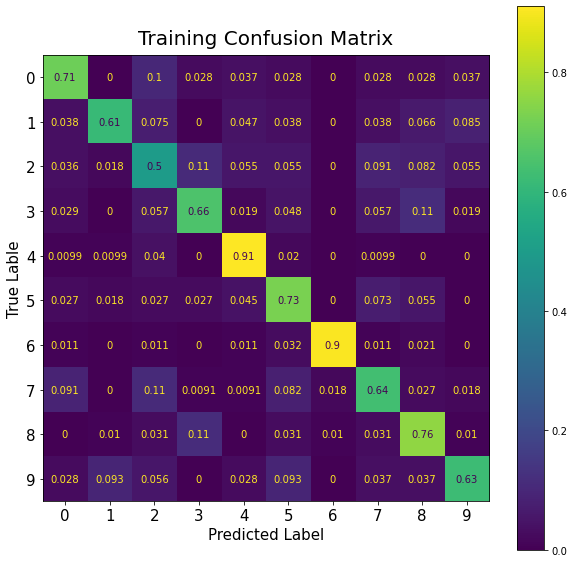

In [29]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
plot_confusion_matrix(digit_model, partial_X_train_product, y_digit_train, normalize='true', ax=axs)
axs.tick_params(labelsize=15)
axs.set_xlabel('Predicted Label', fontsize=15)
axs.set_ylabel('True Lable',fontsize=15)
axs.set_title('Training Confusion Matrix', fontsize=20, y=1.01)

As we can see from the training confusion matrix when we look at digit 2 we can clearly see that the model struggled to classifiy this digit since it only classified 50% of the samples (that were 2) correctly. It confused digit 2 with digit 9 the most.

Text(0.5, 1.01, 'Validation Confusion Matrix')

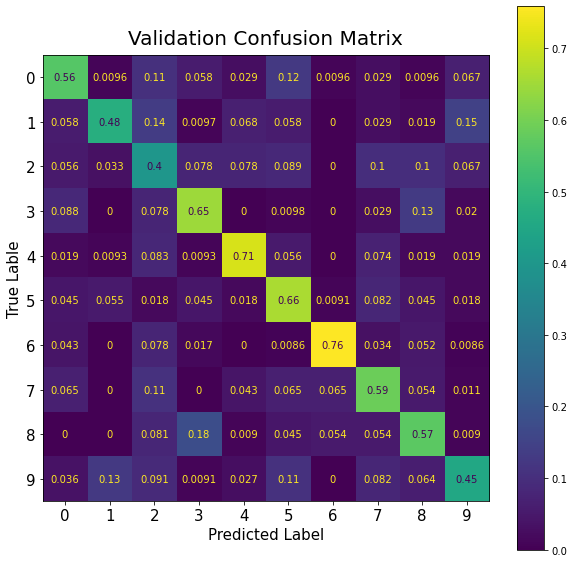

In [46]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
plot_confusion_matrix(digit_model, X_val_product, y_digit_val, normalize='true', ax=axs)
axs.tick_params(labelsize=15)
axs.set_xlabel('Predicted Label', fontsize=15)
axs.set_ylabel('True Lable',fontsize=15)
axs.set_title('Validation Confusion Matrix', fontsize=20, y=1.01)

We draw the same conclusion when it comes to digit 2 in the validation confusion matrix, however we can clearly see that the models performance on unseen data is quite low.

## Intonation Model:

Get the labels that are going to be used for the intonation model:

In [31]:
y_intonation_train = [val[1] for val in partial_y_train_product]
y_intonation_val = [val[1] for val in y_val_product]

(Same procedure used now as in the single digit model)

In [32]:
## Let's take advantage of this library and select a few models
classifiers = []

svc_clf = svm.SVC()
classifiers.append(svc_clf)

mlp = MLPClassifier()
classifiers.append(mlp)

knn = KNeighborsClassifier()
classifiers.append(knn)

dt = DecisionTreeClassifier()
classifiers.append(dt)

sgd = SGDClassifier()
classifiers.append(sgd)

In [33]:
parameters = []

parameters_svc = {'C': np.logspace(-3, 2, 6),  
              'gamma': np.logspace(-3, 2, 6), 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf']}  
parameters.append(parameters_svc)

parameters_mlp = {'max_iter': [30,50,75,100,120,200],
                  'hidden_layer_sizes':[(100,2), (80,2), (60,2), (40,2)],
                  'learning_rate': ['constant', 'adaptive'],
                  'learning_rate_init': [0.001,0.003,0.005,0.0009],
                 'activation': ['relu', 'tanh', 'logistic']}

parameters.append(parameters_mlp)

parameters_knn = {'n_neighbors': [2, 4, 5, 8,10], "weights": ['uniform','distance'] }
parameters.append(parameters_knn)

parameters_dt = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'],
                'max_depth': np.arange(3, 10)}
parameters.append(parameters_dt)

parameters_sgd = {'max_iter': [100,200,500,1000], 'loss':['hinge', 'log', 'perceptron'],
                  'penalty': ['l1', 'l2']}
parameters.append(parameters_sgd)

In [35]:
for i in tqdm(range(len(classifiers))):
    
    model_grid_into = GridSearchCV(classifiers[i], parameters[i], refit=True, n_jobs = -1, verbose=1)
    model_grid_into.fit(partial_X_train_product, y_intonation_train)
    print('Clssifier:', str(classifiers[i]))
    print(classification_report(y_intonation_val, model_grid_into.predict(X_val_product)))

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 173 out of 180 | elapsed:  1.8min remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished
 20%|██        | 1/5 [02:04<08:17, 124.34s/it]

Clssifier: SVC()
              precision    recall  f1-score   support

           0       0.60      0.67      0.63       289
           1       0.60      0.59      0.60       258
           2       0.48      0.48      0.48       246
           3       0.63      0.54      0.58       253

    accuracy                           0.58      1046
   macro avg       0.58      0.57      0.57      1046
weighted avg       0.58      0.58      0.57      1046

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 12.6min finished
/home/diogo_mota/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 40%|████      | 2/5 [14:39<15:40, 313.51s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Clssifier: MLPClassifier()
              precision    recall  f1-score   support

           0       0.55      0.80      0.65       289
           1       0.58      0.26      0.36       258
           2       0.40      0.17      0.24       246
           3       0.48      0.76      0.59       253

    accuracy                           0.51      1046
   macro avg       0.50      0.50      0.46      1046
weighted avg       0.50      0.51      0.47      1046

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
 60%|██████    | 3/5 [14:40<07:19, 219.68s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Clssifier: KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.46      0.56      0.50       289
           1       0.50      0.49      0.49       258
           2       0.35      0.34      0.35       246
           3       0.51      0.40      0.44       253

    accuracy                           0.45      1046
   macro avg       0.45      0.45      0.45      1046
weighted avg       0.45      0.45      0.45      1046

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.2s finished
 80%|████████  | 4/5 [14:41<02:34, 154.14s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Clssifier: DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       289
           1       0.56      0.56      0.56       258
           2       0.44      0.35      0.39       246
           3       0.59      0.53      0.56       253

    accuracy                           0.54      1046
   macro avg       0.53      0.53      0.53      1046
weighted avg       0.53      0.54      0.53      1046

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.3s finished
100%|██████████| 5/5 [14:44<00:00, 176.93s/it]

Clssifier: SGDClassifier()
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       289
           1       0.55      0.38      0.45       258
           2       0.32      0.36      0.34       246
           3       0.50      0.60      0.55       253

    accuracy                           0.46      1046
   macro avg       0.47      0.46      0.46      1046
weighted avg       0.47      0.46      0.46      1046



In [36]:
intonation_model = model_grid_into.best_estimator_

In [47]:
intonation_model

SGDClassifier(loss='log', max_iter=200, penalty='l1')

## Product Test: 

With both models trained we can finally test our product!

In [37]:
## Separate the test digit labels from the test intonation labels
y_digit_test = [val[0] for val in y_test_product]
y_intonation_test = [val[1] for val in y_test_product]

In [38]:
## Get the features of the sequence of three numbers and their respective labels
password_list = [[(X_test_product[i], X_test_product[i+1], X_test_product[i+2]), (y_digit_test[i], y_digit_test[i+1], y_digit_test[i+2]),(y_intonation_test[i], y_intonation_test[i+1], y_intonation_test[i+2])] for i in range(0, len(X_test_product)-3, 3)]

In [39]:
## Here I define the function that allows us to predict the intonation and the digit
def make_prediction(model1, model2, feature):
    return model1.predict(feature.reshape(1,-1))[0], model2.predict(feature.reshape(1,-1))[0]

In [40]:
## Now for every sequence we separate the features of the 3 audio files and predict their corresponding digit and intonation
pass_pred = []
for feat in password_list:
    
    num1, into1 = make_prediction(digit_model, intonation_model, np.array(feat[0][0])) ## features of the first digit used here
    num2, into2 = make_prediction(digit_model, intonation_model, np.array(feat[0][1])) ## features of the second digit used here
    num3, into3 = make_prediction(digit_model, intonation_model, np.array(feat[0][2])) ## features of the third digit used here
    
    pass_pred.append(np.array([[num1, num2, num3], [into1, into2, into3]]))

In [41]:
## Let's separate the labels
y_digit_sequence = [tup[1] for tup in password_list]
y_intonation_sequence = [tup[2] for tup in password_list]

In [42]:
## Let's separate the digit predictions from the intonation predictions
y_digit_seq_pred = [value[0] for value in pass_pred] 
y_into_seq_pred = [value[1] for value in pass_pred]

In [43]:
## Finally let's see how our product performed. In order for our product to correctly predict the sequence
## it needs to have predict all 3 numbers and their intonations correclty, one mistake and the sequence predicted
## is incorrect
miss_count=0
right_count=0
for i in range(len(y_digit_seq_pred)):
    digit_sequence = y_digit_seq_pred[i] == y_digit_sequence[i]
    intonation_sequence = y_into_seq_pred[i] == y_intonation_sequence[i]
    if False in digit_sequence or False in intonation_sequence: ## check if there is any difference between the labels and the predictions
        #print(digit_sequence, intonation_sequence)
        miss_count+=1 ## add the number of incorrect sequences
    else:
        right_count+=1 ## add the number of correct sequences

In [44]:
## Let's calculate the accuracy
accuracy = right_count/(miss_count+right_count)
print('Accuracry:', accuracy)

Accuracry: 0.011494252873563218


Unfortunately our product performed terribly. However this is understandable given the quality of both the intonation and the digit model. Futhermore having to predict 3 numbers and 3 intonations without any mistakes was a hard task from the get go with so little time to do so.

What could be done in the future? Well we would not only need more audio files for single digits, but their quality would also need to be improved. When it comes to the models, I would have to experiment and investigate more on what type of features would allow the models to perform better. Finally I would need to turn to more advanced models such as neural network and deep learning models in order to get satisfying results.

Even though our product's prerformance was very low, this doesn't mean that the single digit classifier and the intonation classifer performed poorly:

In [66]:
y_digit = np.array([val for tup in y_digit_sequence for val in tup]) ## flatten all the digit labels
y_into = np.array([val for tup in y_intonation_sequence for val in tup]) ## flatten all the intonation labels

y_digit_pred = np.array([val for tup in y_digit_seq_pred for val in tup]) ## flatten all the digit predictions
y_into_pred = np.array([val for tup in y_into_seq_pred for val in tup]) ## flatten all the intonation predictions

In [69]:
print('Single digit model testing accuracy', np.mean(y_digit_pred==y_digit))
print('Intonation model testing accuracy', np.mean(y_into_pred==y_into))

Single digit model testing accuracy 0.5586206896551724
Intonation model testing accuracy 0.43908045977011495


As we can see, even though these accuracies are not impressive this was just to show that our product accuracy is not the same as the accuracy of the models that it uses.